In [9]:
include("../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [10]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots, UnicodePlots

In [11]:
# Parameters
method_eigenvector     = "CG"    # CG for Cauchy-Green Method, TO for Transfer Operator Method
method_linear_response = "CG"    # same as above
grid_resolution        = 1000
quadrature_order       = 1
selected_ev            = 4;      # which Eigenvector to choose
ϵ                      = 0.001     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [12]:
T(x ,p) = [rem2pi(x[1] + x[2] + (p+a)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (p+a)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [13]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [14]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [15]:
# assemble K
if method_eigenvector == "CG"
    DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
    A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
    @time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
    nothing
elseif method_eigenvector == "TO"
    @time D⁰ = assembleStiffnessMatrix(ctx, bdata=bdata)
    @time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0), bdata=bdata)
    K = 0.5(D⁰+D¹);
    nothing
end

 10.689396 seconds (201.71 M allocations: 6.780 GiB, 11.18% gc time)


In [7]:
using ForwardDiff

In [8]:
parameter_autodiff(flowmap, u, p) = ForwardDiff.jacobian(x -> flowmap(x[1:end - 1], x[end]), vcat(u, p))[:,end]

parameter_autodiff (generic function with 1 method)

In [16]:
parameter_autodiff2(flowmap, u, p) = ForwardDiff.derivative(param -> flowmap(u, param), p)

parameter_autodiff2 (generic function with 1 method)

In [17]:
parameter_autodiff(T, [0.01,0.02], 0)

2-element Array{Float64,1}:
 0.009999833334166664
 0.009999833334166664

In [18]:
parameter_autodiff2(T, [0.01,0.02], 0)

2-element Array{Float64,1}:
 0.009999833334166664
 0.009999833334166664

In [37]:
@time parameter_autodiff(T, [0.01,0.02], 0)

  0.000084 seconds (38 allocations: 2.250 KiB)


2-element Array{Float64,1}:
 0.009999833334166664
 0.009999833334166664

In [38]:
@time parameter_autodiff2(T, [0.01,0.02], 0)

  0.000025 seconds (18 allocations: 704 bytes)


2-element Array{Float64,1}:
 0.009999833334166664
 0.009999833334166664

In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
u₀ = u₀[:,selected_ev]
u₀ = u₀ ./ (u₀'*M*u₀)       #L2 normalization
λ₀ = λ₀[selected_ev]

100.942953 seconds (9.53 M allocations: 6.720 GiB, 0.74% gc time)


-1.5000082411835962

In [9]:
# assemble the linear response matrix L
if method_linear_response == "CG"
    Adot = x -> linear_response_tensor_autodiff(T, x, 0)
    @time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata)
    nothing
elseif method_linear_response == "TO"
    @time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0, bdata=bdata)
    nothing
end

 30.992555 seconds (302.29 M allocations: 15.081 GiB, 5.91% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀ ; 0]

#λ_dot = u₀'*L*u₀ / (u₀'*M*u₀)

#lhs = [K-λ₀*M ;
#        u₀'*M ]
#rhs = [(-L + λ_dot*M)*u₀ ; 0]

@time b = lhs \ rhs

u_dot = b[1:end-1]
λ_dot = b[end]

157.174866 seconds (2.36 M allocations: 3.184 GiB, 0.41% gc time)


-3.4205570204598595e-14

In [60]:
# calculate the exact uϵ
if method_eigenvector == "CG"
    DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
elseif method_eigenvector == "TO"
    D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ))
    Kϵ = 0.5(D⁰+D¹ϵ)
end
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
uϵ = uϵ[:,selected_ev]
uϵ = uϵ ./ (uϵ'*M*uϵ)        #L2 normalization
λϵ = λϵ[selected_ev]

-1.5000082411833602

In [61]:
# calculate the exact u-ϵ
if method_eigenvector == "CG"
    DTminusϵ(x) = linearized_transfer_function_autodiff(y -> T(y,-ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
elseif method_eigenvector == "TO"
    D¹minusϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,-ϵ))
    Kminusϵ = 0.5(D⁰+D¹minusϵ)
end
λminusϵ, uminusϵ = eigs(Kminusϵ, M, which=:SM)
uminusϵ = uminusϵ[:,selected_ev]
uminusϵ = uminusϵ ./ (uminusϵ'*M*uminusϵ)        #L2 normalization
λminusϵ = λminusϵ[selected_ev]

-1.5000082411834865

In [13]:
λ₀ + ϵ*λ_dot

-1.5000082411836133

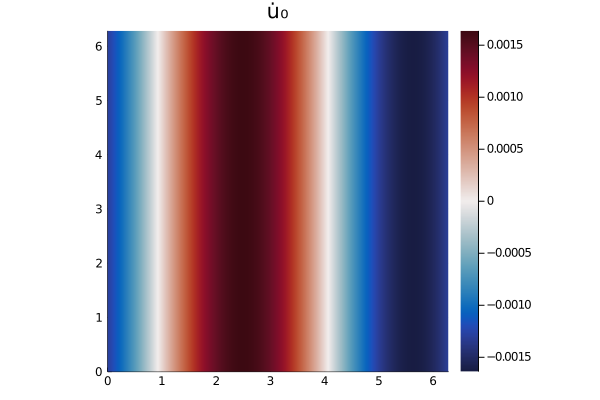

In [62]:
plot_u(ctx, u_dot,grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance, title="u̇ ₀")#, clims=(-0.002,0.002))

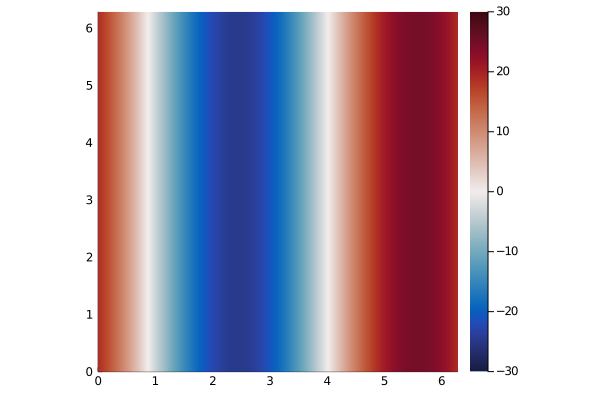

In [69]:
plot_u(ctx, (uminusϵ - u₀) ./ ϵ, grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance, clims=(-30,30))

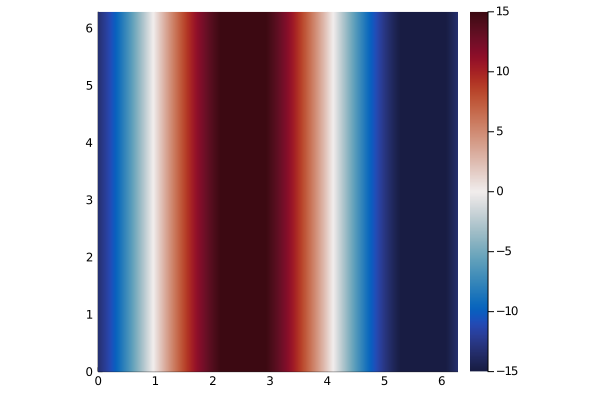

In [70]:
plot_u(ctx, (uϵ - u₀) ./ ϵ, grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance, clims=(-15,15))

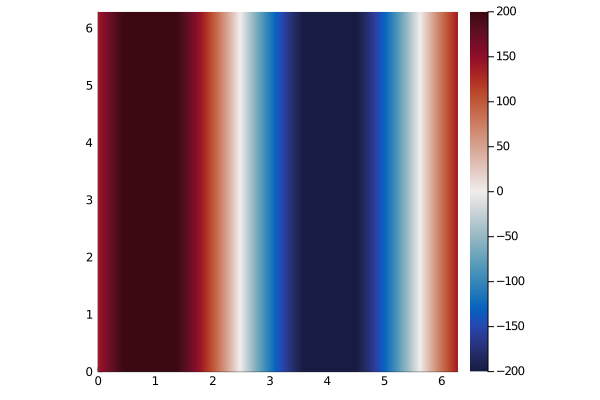

In [71]:
plot_u(ctx, (uϵ + uminusϵ) ./ (2ϵ), grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance, clims=(-200,200))

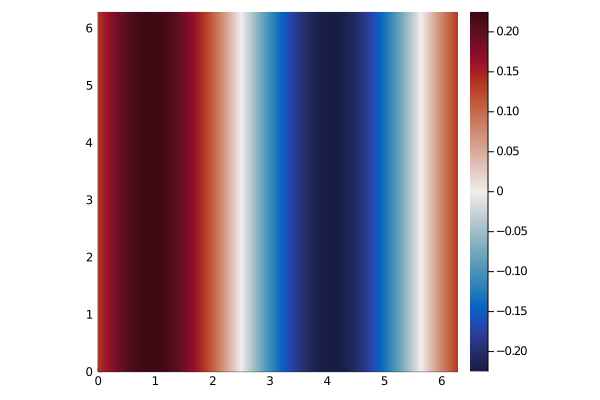

In [66]:
plot_u(ctx, u₀,grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance)#, clims=(-0.3,0.3))

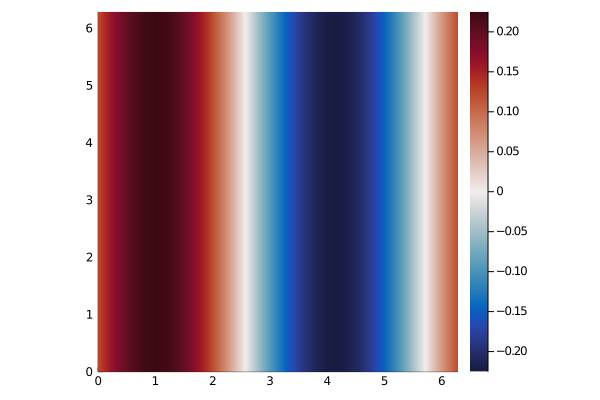

In [67]:
plot_u(ctx, uϵ,grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance)#, clims=(-0.3,0.3))

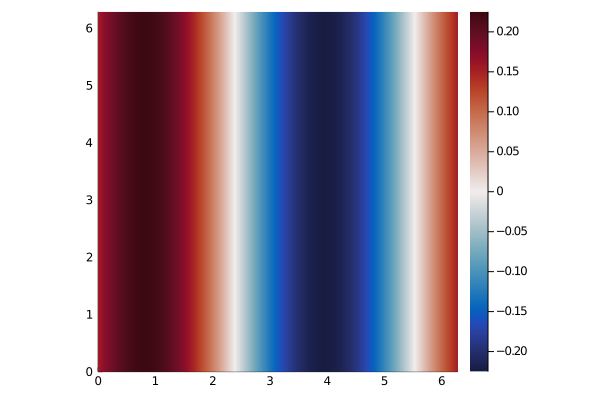

In [68]:
plot_u(ctx, uminusϵ,grid_resolution, grid_resolution, bdata=bdata,
       colorbar=:left, color=:balance)#, clims=(-0.3,0.3))

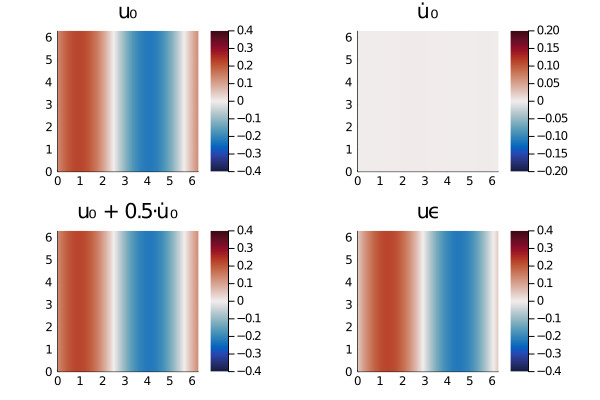

In [21]:
color = :balance
cmin = -0.4
cmax = 0.4

cmin_d = -0.2
cmax_d = 0.2

original      = plot_u(ctx, u₀,           grid_resolution, grid_resolution, colorbar=:left, 
                       color=color, title="u₀", clims=(cmin,cmax), bdata=bdata)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, colorbar=:left, 
                       color=color, title="u̇ ₀",clims=(cmin_d,cmax_d), bdata=bdata)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, colorbar=:left, 
                       color=color, title="u₀ + $(ϵ)⋅u̇ ₀",clims=(cmin,cmax), bdata=bdata)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, colorbar=:left, 
                       color=color, title="uϵ",clims=(cmin,cmax), bdata=bdata)
Plots.plot(original,derivative,extrapolated,exact)

## Additional Interesting Plots

In [22]:
UnicodePlots.spy(K, title = "Sparsity Pattern of K")

                     Sparsity Pattern of K
          ┌──────────────────────────────────────────┐    
        1 │⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈│ > 0
          │⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ < 0
          │⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀

In [23]:
UnicodePlots.spy(L, title = "Sparsity Pattern of L")

                     Sparsity Pattern of L
          ┌──────────────────────────────────────────┐    
        1 │⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈│ > 0
          │⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ < 0
          │⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀

In [24]:
# A₀ and Ȧ₀
DT₀(x) = linearized_transfer_function_autodiff(y -> transfer_operator(y,0) , x)
A₀(x)  =  0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))

Ṫ(x)  = Main.CoherentStructures.parameter_autodiff(transfer_operator, x, 0)
DṪ(x) = linearized_transfer_function_autodiff(Ṫ, x)
Ȧ₀(x)  =  0.5*(inv(DT₀(x)) ⋅ DṪ(x) ⋅ dott(inv(DT₀(x))))

trace_A₀_values = [Tensors.tr(A₀(ctx.grid.nodes[i].x)) for i in 1:ctx.n]
#trace_A₀_values =  sign.(trace_A₀_values).*log.(abs.(trace_A₀_values))
trace_A₀_plot = plot_u(ctx, trace_A₀_values, grid_resolution, grid_resolution, 
    colorbar=:left, color=:coolwarm, title="Trace of A₀")

trace_Ȧ₀_values = [Tensors.tr(Ȧ₀(ctx.grid.nodes[i].x)) for i in 1:ctx.n]
#trace_Ȧ₀_values =  sign.(trace_Ȧ₀_values).*log.(abs.(trace_Ȧ₀_values))
trace_Ȧ₀_plot = plot_u(ctx, trace_Ȧ₀_values, grid_resolution, grid_resolution,
    colorbar=:left, color=:coolwarm, title="Trace of Ȧ₀")

Tdot_plot(x) = Main.CoherentStructures.parameter_autodiff(transfer_operator, x, 0)
Tdot_x_values = [Tdot_plot(ctx.grid.nodes[i].x)[1] for i in 1:ctx.n]
Tdot_y_values = [Tdot_plot(ctx.grid.nodes[i].x)[2] for i in 1:ctx.n]

Tdot_x_values_plot = plot_u(ctx, Tdot_x_values, grid_resolution, grid_resolution, 
    colorbar=:left, color=:coolwarm, title="x-component of Tdot")
Tdot_y_values_plot = plot_u(ctx, Tdot_y_values, grid_resolution, grid_resolution, 
    colorbar=:left, color=:coolwarm, title="y-component of Tdot")

Plots.plot(trace_A₀_plot, trace_Ȧ₀_plot, Tdot_x_values_plot, Tdot_y_values_plot)


UndefVarError: UndefVarError: transfer_operator not defined

In [25]:
ctx_plot, _ = regularTriangularGrid((10, 10), LL, UR, quadrature_order = quadrature_order)
bdata_plot = BoundaryData(ctx_plot, pred);
flow_map_t(j) = Vec{2}(T(ctx_plot.grid.nodes[j].x,0))
new_ctx_plot,_,_ = Main.CoherentStructures.adaptiveTOFutureGrid(ctx_plot,flow_map_t,flow_map_mode=1,bdata=bdata_plot)

(Main.CoherentStructures.GridContext{2,JuAFEM.Grid{2,JuAFEM.Cell{2,3,3},Float64},JuAFEM.Lagrange{2,JuAFEM.RefTetrahedron,1},JuAFEM.Lagrange{2,JuAFEM.RefTetrahedron,1},JuAFEM.DofHandler{2,JuAFEM.Cell{2,3,3},Float64},JuAFEM.QuadratureRule{2,JuAFEM.RefTetrahedron,Float64},Main.CoherentStructures.DelaunayCellLocator}(JuAFEM.Grid{2,JuAFEM.Cell{2,3,3},Float64}(JuAFEM.Cell{2,3,3}[JuAFEM.Cell{2,3,3}((6, 4, 5)), JuAFEM.Cell{2,3,3}((64, 17, 81)), JuAFEM.Cell{2,3,3}((13, 15, 14)), JuAFEM.Cell{2,3,3}((31, 41, 40)), JuAFEM.Cell{2,3,3}((59, 68, 58)), JuAFEM.Cell{2,3,3}((70, 61, 62)), JuAFEM.Cell{2,3,3}((80, 13, 79)), JuAFEM.Cell{2,3,3}((37, 54, 28)), JuAFEM.Cell{2,3,3}((47, 48, 56)), JuAFEM.Cell{2,3,3}((26, 18, 35))  …  JuAFEM.Cell{2,3,3}((42, 32, 33)), JuAFEM.Cell{2,3,3}((33, 43, 42)), JuAFEM.Cell{2,3,3}((10, 12, 24)), JuAFEM.Cell{2,3,3}((33, 24, 34)), JuAFEM.Cell{2,3,3}((25, 12, 18)), JuAFEM.Cell{2,3,3}((24, 25, 34)), JuAFEM.Cell{2,3,3}((22, 8, 23)), JuAFEM.Cell{2,3,3}((32, 23, 33)), JuAFEM.Cell{2

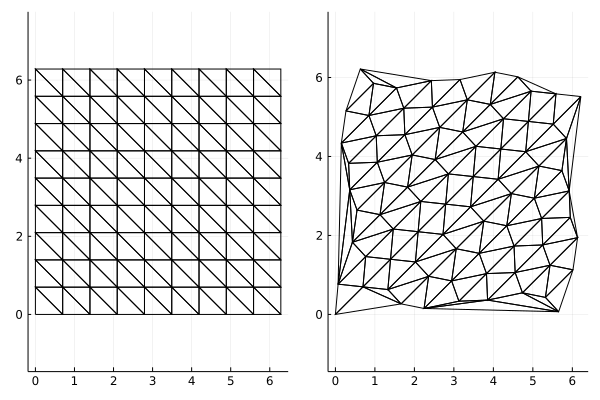

In [26]:
original_grid = Main.CoherentStructures.plot_grid(ctx_plot,bdata=bdata_plot)
adapted_grid = Main.CoherentStructures.plot_grid(new_ctx_plot,bdata=bdata_plot)
Plots.plot(original_grid,adapted_grid)